## SMS SPAM Detection using NLP

For this analysis, we will be using public dataset available at http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/

The dataset is created by Tiago A. Almeida and José María Gómez Hidalgo.

The dataset is comprises 5,574 English, real and non-enconded messages, tagged according being legitimate (ham) or spam.

### Load Data

In [1]:
# Importing libraries

import pandas as pd

In [2]:
df_sms = pd.read_csv('data/SMSSpamCollection.csv', sep = '\t', header = None)
df_sms.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# Assigning column names

df_sms.columns=['category', 'message']
df_sms.head()

,category,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Visualize

In [4]:
# Let's look at our data

df_sms.category.value_counts()

ham     4825
spam     747
Name: category, dtype: int64

In [5]:
# Let's plot this

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

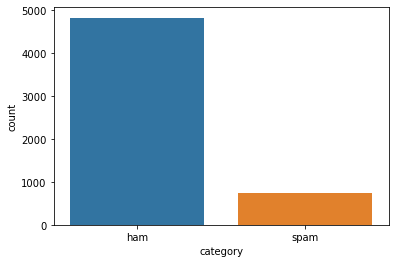

In [6]:
sns.countplot(df_sms.category)
plt.show()

In [7]:
# Let's see a word cloud

df_spam  = df_sms[df_sms.category == 'spam'].copy()
df_ham = df_sms[df_sms.category == 'ham'].copy()

In [8]:
import wordcloud

def generate_wordcloud(data_frame, category):
    text = ' '.join(data_frame['message'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(category, fontsize=20 )
    plt.show()

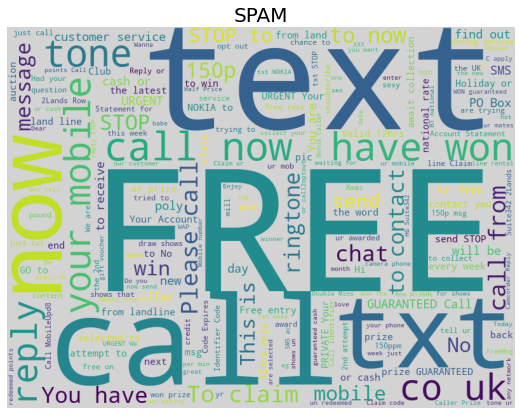

In [9]:
generate_wordcloud(df_spam, 'SPAM')

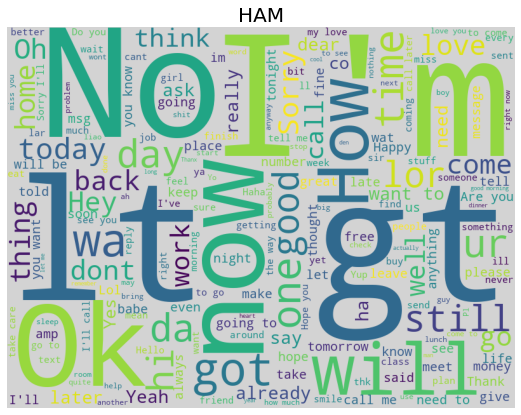

In [10]:
generate_wordcloud(df_ham, 'HAM')

### Preparing Data

In [11]:
# Converting category to numerical format

df_sms['category'] = df_sms['category'].map( 
    {'spam': 1, 'ham': 0} )

In [12]:
df_sms.head()

,category,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
# Importing libraries for model building and predictions

# for model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

# for text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# split data into train and test set
from sklearn.model_selection import train_test_split

In [14]:
# Splitting dataset for training and test

X = df_sms['message'].values
y = df_sms['category'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [15]:
# prepare tokenizer

token = Tokenizer()
token.fit_on_texts(X_train)

In [16]:
# integer encode the documents

encoded_train = token.texts_to_sequences(X_train)
encoded_test = token.texts_to_sequences(X_test)
print(encoded_train[0:2])

[[87, 2, 172, 485, 461, 121, 33, 5, 3857, 3858, 315, 1268, 30, 2603, 67, 82, 2, 1657, 2, 316, 238], [246, 873, 15, 54, 8, 462, 160, 21, 25, 95, 1658, 77, 1, 61, 1120, 3859, 33, 174, 3, 53, 2604]]


In [17]:
# pad documents to a max length of 8words
max_length = 8

padded_train = pad_sequences(encoded_train, maxlen = max_length, padding = 'post')
padded_test = pad_sequences(encoded_test, maxlen = max_length, padding = 'post')

print(padded_train)

[[2603   67   82 ...    2  316  238]
 [  61 1120 3859 ...    3   53 2604]
 [  49   85   97 ...    6  247   99]
 ...
 [1640   31 2485 ...  254   31 2486]
 [ 944 1460 1197 ...    0    0    0]
 [ 116   74   37 ...    9 3219 1396]]


### Building Model

In [18]:
vocab_size = len(token.word_index) + 1

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length = max_length))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 24)             190896    
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               96500     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [19]:
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)

# fit the model
model.fit(x = padded_train,
          y = y_train,
          epochs = 50,
          validation_data = (padded_test, y_test),
          verbose=1,
          callbacks=[early_stop])

Epoch 1/50
140/140 [==============================] - 1s 4ms/step - loss: 0.1880 - accuracy: 0.9273 - val_loss: 0.0660 - val_accuracy: 0.9812
Epoch 2/50
140/140 [==============================] - 0s 2ms/step - loss: 0.0494 - accuracy: 0.9836 - val_loss: 0.0775 - val_accuracy: 0.9803
Epoch 3/50
140/140 [==============================] - 0s 2ms/step - loss: 0.0184 - accuracy: 0.9946 - val_loss: 0.1148 - val_accuracy: 0.9785
Epoch 4/50
140/140 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 0.9991 - val_loss: 0.1709 - val_accuracy: 0.9821
Epoch 5/50
140/140 [==============================] - 0s 3ms/step - loss: 1.5978e-04 - accuracy: 1.0000 - val_loss: 0.2109 - val_accuracy: 0.9821
Epoch 6/50
140/140 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.2798 - val_accuracy: 0.9821
Epoch 7/50
140/140 [==============================] - 0s 3ms/step - loss: 4.8380e-08 - accuracy: 1.0000 - val_loss: 0.2827 - val_accuracy: 0.981

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def c_report(y_true, y_pred):
   print("Classification Report")
   print(classification_report(y_true, y_pred))
   acc_sc = accuracy_score(y_true, y_pred)
   print("Accuracy : "+ str(acc_sc))
   return acc_sc

def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

In [22]:
preds = (model.predict(padded_test) > 0.5).astype("int32")

In [23]:
c_report(y_test, preds)

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.89      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy : 0.9829596412556054


0.9829596412556054

In [26]:
accuracy_score(y_test, preds)

0.9829596412556054

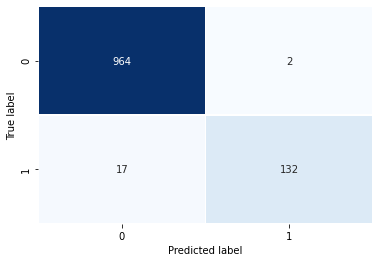

In [27]:
plot_confusion_matrix(y_test, preds)

In [28]:
model.save("spam_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: spam_model\assets


In [29]:
import pickle

with open('spam_model/tokenizer.pkl', 'wb') as output:
   pickle.dump(token, output, pickle.HIGHEST_PROTOCOL)

In [30]:
import tensorflow as tf

s_model = tf.keras.models.load_model("spam_model")
with open('spam_model/tokenizer.pkl', 'rb') as input:
    tokenizer = pickle.load(input)

In [31]:
sms = ["Hi, I'll be late, lets check this tomorrow "]
sms_proc = token.texts_to_sequences(sms)
sms_proc = pad_sequences(sms_proc, maxlen=max_length, padding='post')
pred = (model.predict(sms_proc) > 0.5).astype("int32").item()
print(pred)

0
